# Task2:乙醇销售数据回归

In [125]:
# 导入库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
torch.set_default_tensor_type(torch.DoubleTensor)

In [126]:
device = torch.device('cuda:2')

### 数据处理

In [127]:
# 读取原始文件，并设置日期为索引
data = pd.read_csv('alcohol.csv', index_col='DATE')
# 将data_index设置为时间格式
data.index = pd.to_datetime(data.index)
time = data.index

# 转为 array
data = data['S4248SM144NCEN']
series = np.array(data)

In [128]:
time

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

### 数据可视化

In [129]:
# 定义绘制函数
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    # 设置图例
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

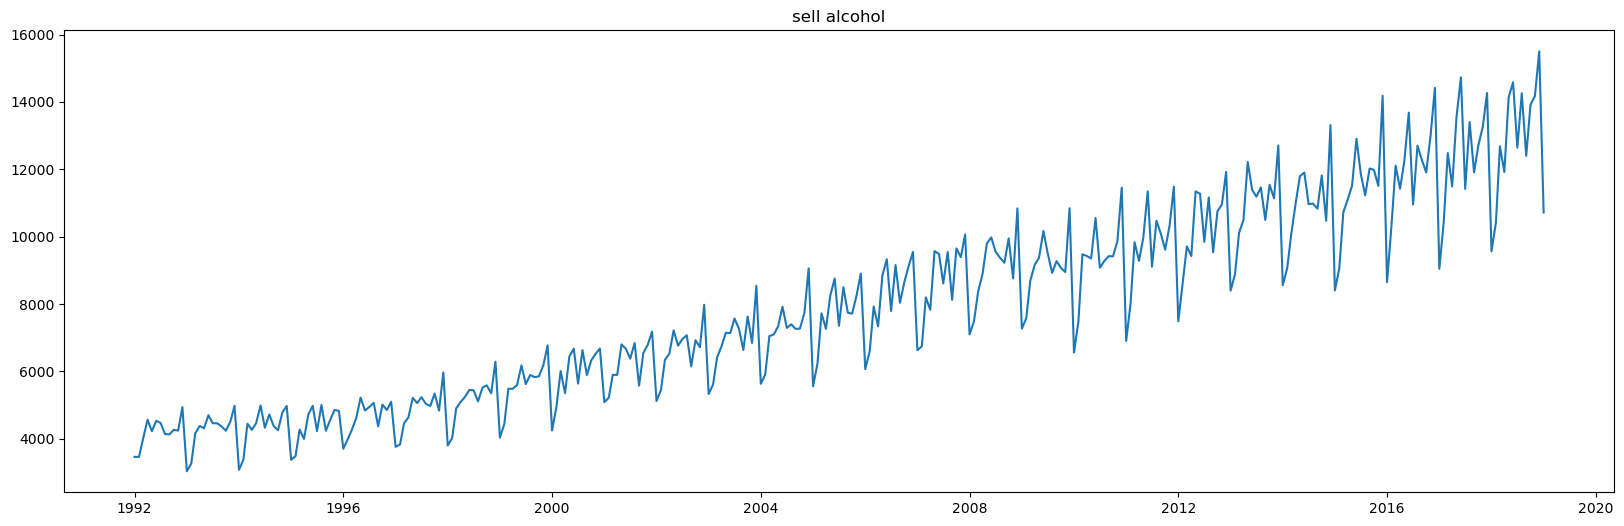

In [130]:
import matplotlib.ticker as mticker

fig,ax = plt.subplots(figsize=(20, 6))
plt.plot(time,series)
plt.title('sell alcohol')
plt.show()

### 划分训练集、测试集、batch

In [131]:
def train_test_split(series, split_prop): # split_prop: 训练集占比 
    train = series[:int(len(series)*split_prop)]
    test = series[int(len(series)*split_prop):]
    return train, test

# 将数据划分为指定大小的batch
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

### 滑窗、划分特征/标签函数

In [132]:
# 滑窗、打乱
def data_process(train, test, window_size):
    # 将数据转为tensor，并进行滑窗，得到短序列
    train_tensor = torch.from_numpy(train)
    print('滑窗之前：', train_tensor.shape)
    train_tensor = train_tensor.squeeze()
    train_window_split = train_tensor.unfold(0, window_size, 1)
    print('滑窗之后：', train_window_split.shape)
    train_set = train_window_split.numpy()

    test_tensor = torch.from_numpy(test)
    print('滑窗之前：', test_tensor.shape)
    test_tensor = test_tensor.squeeze()
    test_window_split = test_tensor.unfold(0, window_size, 1)
    print('滑窗之后：', test_window_split.shape)
    test_set = test_window_split.numpy()

    # 打乱训练集数据
    train_temp1 = train_set.tolist()
    random.shuffle(train_temp1)
    train_templ2 = np.array(train_temp1)

    # 将短序列分为feature、label
    train_feature_array = train_templ2[:, :window_size-1]
    train_label_array = train_templ2[:, window_size-1:]
    test_feature_array = test_set[:, :window_size-1]
    test_label_array = test_set[:, window_size-1:]

    # 将 ndarray转为tensor
    train_feature_tensor = torch.from_numpy(train_feature_array).double()
    train_label = torch.from_numpy(train_label_array).double()
    test_feature_tensor = torch.from_numpy(test_feature_array).double()
    test_label = torch.from_numpy(test_label_array).double()

    # 扩展数据维度，符合 CNN 输入(样本数，通道数，特征数)
    train_feature = train_feature_tensor.reshape(train_feature_tensor.shape[0], 1, train_feature_tensor.shape[1])
    test_feature = test_feature_tensor.reshape(test_feature_tensor.shape[0], 1, test_feature_tensor.shape[1])

    return train_feature, train_label, test_feature, test_label

### 数据处理

In [133]:
split_prop = 0.7
train, test = train_test_split(series, split_prop)
window_size = 13
# 数据处理
train_feature, train_label, test_feature, test_label = data_process(train, test, window_size)
# 分别输出训练集、测试集的特征和标签
print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

滑窗之前： torch.Size([227])
滑窗之后： torch.Size([215, 13])
滑窗之前： torch.Size([98])
滑窗之后： torch.Size([86, 13])
torch.Size([215, 1, 12])
torch.Size([215, 1])
torch.Size([86, 1, 12])
torch.Size([86, 1])


### 复现一维卷积神经网络

平均池化

In [134]:
# 定义卷积神经网络
class ConvModule1(nn.Module):
    def __init__(self):
        super(ConvModule1, self).__init__()
        # 一层一维卷积
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # 将输出通道变为单值
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # print('input:', x.shape)
        out = self.conv1(x) # 一维卷积
        # print('conv1:', out.shape)
        out = F.avg_pool1d(out, kernel_size=2, padding=1) # 平均池化
        # print('pool1:', out.shape)
        out = self.conv2(out) # 一维卷积
        # print('conv2:', out.shape)
        out = F.avg_pool1d(out, 3) # 平均池化
        # print('pool2:', out.shape)
        out = out.squeeze()
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
# 构建网络
net = ConvModule1().to(device)

In [135]:
# 定义损失函数-均方误差
def square_loss(feature, label):
    return (net(feature) - label)**2/2

### 参数初始化

In [136]:
for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)

lr = 0.01
num_epochs = 250
batch_size = 64
loss = square_loss
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### 训练模型

In [137]:
train_loss, test_loss = [], []
# 模型训练
for epoch in range(num_epochs):
    train_l, test_l = 0.0, 0.0
    for X,y in data_iter(batch_size, train_feature, train_label):
        X, y = X.to(device), y.to(device)
        # print(X.shape)
        l = loss(X, y).sum() # 计算 loss
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward() # 反向传播
        optimizer.step() # 更新参数
    
    train_l = loss(train_feature.to(device), train_label.to(device)).mean().detach().item()
    test_l = loss(test_feature.to(device), test_label.to(device)).mean().detach().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss: %f, test loss: %f' % (epoch+1, train_l, test_l))

epoch 1, train loss: 14854535.347428, test loss: 43407079.161534


epoch 2, train loss: 26681735.407447, test loss: 77775135.885801
epoch 3, train loss: 6820881.688983, test loss: 19990055.403806
epoch 4, train loss: 13725266.513603, test loss: 40116309.950860
epoch 5, train loss: 10540914.354606, test loss: 30834920.943643
epoch 6, train loss: 929078.529025, test loss: 2807687.902173
epoch 7, train loss: 6144077.554705, test loss: 17966144.685555
epoch 8, train loss: 1005954.471588, test loss: 3032388.628394
epoch 9, train loss: 3090260.367091, test loss: 9113736.944273
epoch 10, train loss: 299615.565250, test loss: 965617.368110
epoch 11, train loss: 1478223.641327, test loss: 4386944.595298
epoch 12, train loss: 569185.292478, test loss: 1756782.591446
epoch 13, train loss: 722223.356785, test loss: 2204190.214588
epoch 14, train loss: 524366.481988, test loss: 1614924.301368
epoch 15, train loss: 331239.575655, test loss: 1055716.326928
epoch 16, train loss: 462654.248622, test loss: 1445432.006388
epoch 17, train loss: 300854.747821, test loss: 

### 绘制损失函数曲线

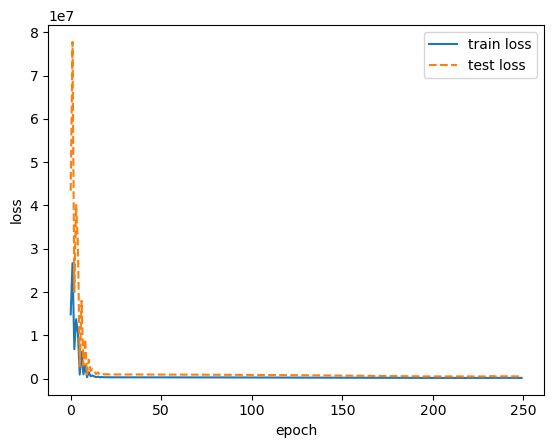

In [138]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, test_loss, label='test loss', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 预测并对比

In [139]:
def predict(x):
    temp = torch.from_numpy(x)
    x_tensor = temp.reshape(1, 1, window_size-1) # 一次只输入一个样本
    return net(x_tensor)

In [140]:
time = data.index.to_list()

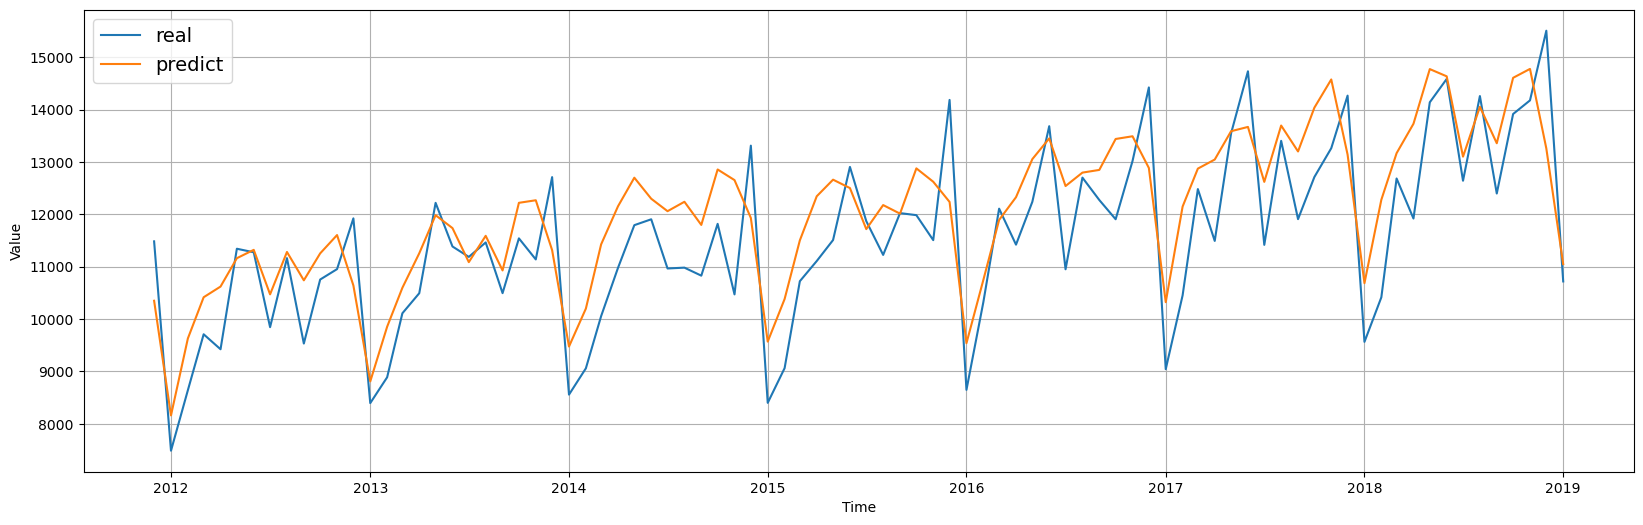

In [141]:
# net = net.to('cpu') # 把 net单独拆下来，放到cpu上；要不然就得把数据搬到 GPU 上

test_predict = []
split_point = int(split_prop * len(series))
test_time = time[split_point+window_size-1:] # 测试集时间 
test_true = series[split_point+window_size-1:] # 测试集真实值
test_predict = net(test_feature.to(device)).squeeze().tolist() # 测试集预测值

plt.figure(figsize=(20, 6))
plot_series(test_time, test_true, label='real')
plot_series(test_time, test_predict, label='predict')
plt.show()

In [142]:
from sklearn.metrics import mean_squared_error as mse

print('MSE:', mse(test_true, test_predict))

MSE: 1029087.2898007936


## 下面对网络结构进行调整，增加一层隐藏层达到 3 层

In [99]:
# 定义卷积神经网络
class ConvModule2(nn.Module):
    def __init__(self):
        super(ConvModule2, self).__init__()
        # 三层卷积
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=2),
            nn.ReLU(inplace=True)
        )
        # 将输出通道变为单值
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        out = self.conv1(x) # 一维卷积
        out = F.avg_pool1d(out, kernel_size=2, padding=1)
        out = self.conv2(out) # 一维卷积
        out = F.avg_pool1d(out, kernel_size=2, padding=1)
        out = self.conv3(out)
        out = F.max_pool1d(out, kernel_size=2)
        out = out.squeeze()
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
# 构建网络
net = ConvModule2().to(device)

### 参数初始化

In [100]:
for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)

lr = 0.01
num_epochs = 250
batch_size = 64
loss = square_loss
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### 训练模型

In [101]:
train_loss, test_loss = [], []
# 模型训练
for epoch in range(num_epochs):
    train_l, test_l = 0.0, 0.0
    for X,y in data_iter(batch_size, train_feature, train_label):
        X, y = X.to(device), y.to(device)
        # print(X.shape, y.shape)
        l = loss(X, y).sum() # 计算 loss
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward() # 反向传播
        optimizer.step() # 更新参数
    
    train_l = loss(train_feature.to(device), train_label.to(device)).mean().detach().item()
    test_l = loss(test_feature.to(device), test_label.to(device)).mean().detach().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss: %f, test loss: %f' % (epoch+1, train_l, test_l))

epoch 1, train loss: 13989030.855835, test loss: 40880728.523610
epoch 2, train loss: 3894294.794133, test loss: 11454643.813925
epoch 3, train loss: 18311423.178218, test loss: 53480792.323103
epoch 4, train loss: 18707883.758809, test loss: 54637281.411960
epoch 5, train loss: 12429356.769979, test loss: 36337604.475762
epoch 6, train loss: 5183439.523989, test loss: 15195567.266201
epoch 7, train loss: 2537200.633032, test loss: 7501728.222160
epoch 8, train loss: 2970979.455602, test loss: 8767302.898078
epoch 9, train loss: 4656217.181408, test loss: 13656515.666920
epoch 10, train loss: 2551700.239499, test loss: 7545566.913138
epoch 11, train loss: 625554.855108, test loss: 1926754.683902
epoch 12, train loss: 1633725.906025, test loss: 4852939.085959
epoch 13, train loss: 1547572.225837, test loss: 4617582.410056
epoch 14, train loss: 592626.696734, test loss: 1823110.457401
epoch 15, train loss: 340725.037037, test loss: 1094275.184799
epoch 16, train loss: 338454.439285, test

### 绘制损失函数曲线

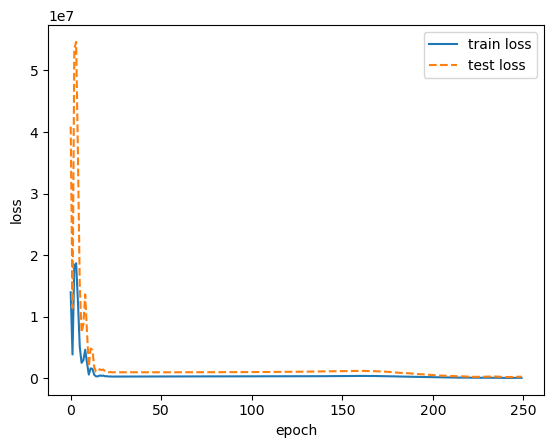

In [102]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, test_loss, label='test loss', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 预测并对比

In [103]:
def predict(x):
    temp = torch.from_numpy(x)
    x_tensor = temp.reshape(1, 1, window_size-1) # 一次只输入一个样本
    return net(x_tensor)

In [104]:
time = data.index.to_list()

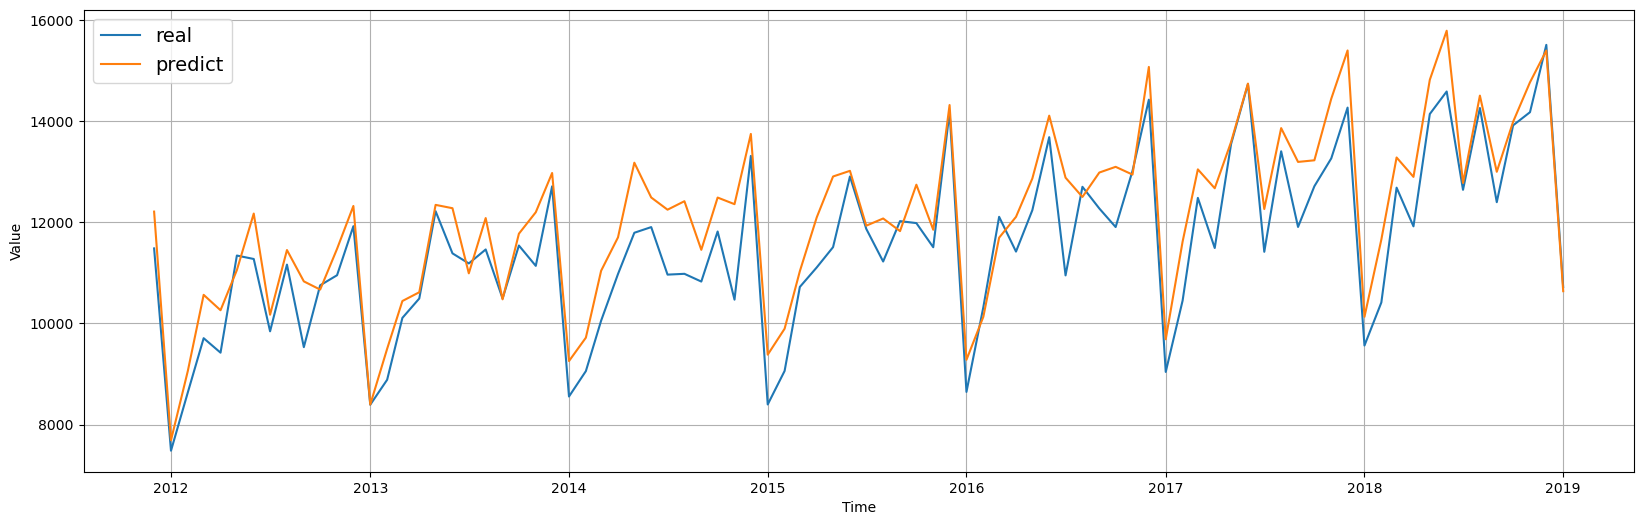

In [105]:
# net = net.to('cpu') # 把 net单独拆下来，放到cpu上；要不然就得把数据搬到 GPU 上

test_predict = []
split_point = int(split_prop * len(series))
test_time = time[split_point+window_size-1:] # 测试集时间 
test_true = series[split_point+window_size-1:] # 测试集真实值
test_predict = net(test_feature.to(device)).detach().squeeze().tolist() # 测试集预测值

plt.figure(figsize=(20, 6))
plot_series(test_time, test_true, label='real')
plot_series(test_time, test_predict, label='predict')
plt.show()

In [106]:
from sklearn.metrics import mean_squared_error as mse

print('MSE:', mse(test_true, test_predict))

MSE: 583320.0975648726


### 总结

1. 与复现 homework1 中的 CNN 相比，之前的 MSE为 100 万左右，经过增加一层隐层，并将最后一层的池化操作从平均池化更换为最大池化，模型的 MSE 降到 50 万左右，可见性能提升了近一倍。那么原因是在一定程度上，网络层数的增加可以增强模型拟合数据的能力，能够增强其对数据的特征提取能力，因此模型表现得更好。
2. 与之前的模型相比：
（1）前馈神经网络的 MSE 大概为 42 万左右
（2）机器学习模型在 SVR 最好，MSE 大概 30 万左右
因此深度神经网络不一定比机器学习等简单模型好，我们不能只注重新的、复杂的模型